In [1]:
import requests
import os
import sys
import tarfile
import pickle

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random
import numpy as np
import chainer
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

from chainer.datasets import split_dataset_random, TupleDataset

## Load dataset

Let's load CIFAR-10 dataset.

### Download tar.gz file

In [9]:
def maybe_download(url, save_dir = './datasets/'):    
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    
    filename = url.split('/')[-1]
    file_path = os.path.join(save_dir, filename)
    if os.path.exists(file_path):
        return file_path
    
    r = requests.get(url)
    if r.status_code == 200:    
        with open(file_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)
    else:
        r.raise_for_status()
        
    return file_path

In [10]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
file_path = maybe_download(url)

### Extract tar file

In [11]:
def extract_tar(file_path):
    target_dir = os.path.dirname(file_path)

    with tarfile.open(file_path) as tar:
        for n in tar.getnames():
            member = os.path.abspath(os.path.join(target_dir, n))
            print(member)
            
            if not member.startswith(os.path.abspath(target_dir)):
                sys.exit(1)

        tar.extractall(path=target_dir)

In [12]:
extract_tar(file_path)

/tmp/notebooks/chainer/datasets/cifar-10-batches-py
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/data_batch_4
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/readme.html
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/test_batch
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/data_batch_3
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/batches.meta
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/data_batch_2
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/data_batch_5
/tmp/notebooks/chainer/datasets/cifar-10-batches-py/data_batch_1


In [13]:
def unpickle(file):

    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Unpickel files

In [14]:
pickled_data_dir = "/tmp/notebooks/chainer/datasets/cifar-10-batches-py"

def load_cifar10(data_dir):
    ## Train data
    train_data = np.empty((0, 3 * 32 * 32), dtype=np.float32)
    train_labels = np.empty((0), dtype=np.int32)

    for i in range(1,6):
        file = os.path.join(pickled_data_dir, "data_batch_{}".format(i))
        batch = unpickle(file)

        train_data = np.vstack((train_data, batch[b'data']))
        train_labels = np.hstack((train_labels, np.array(batch[b'labels'])))

    ## Test data
    file = os.path.join(pickled_data_dir, "test_batch")
    batch = unpickle(file)

    test_data = np.empty((0, 3 * 32 * 32), dtype=np.float32)
    test_labels = np.empty((0), dtype=np.int32)
    test_data = np.vstack((test_data, batch[b'data']))
    test_labels = np.hstack((test_labels, np.array(batch[b'labels'])))
    
    ## Meta
    file = os.path.join(pickled_data_dir, "batches.meta")
    meta = unpickle(file)
    label_names = meta[b'label_names']
    
    train_labels = train_labels.astype(np.int32)
    test_labels = test_labels.astype(np.int32)
    
    return train_data, train_labels, test_data, test_labels, label_names

In [15]:
train_data, train_labels, test_data, test_labels, label_names = load_cifar10(pickled_data_dir)

In [16]:
print("train_data shape: {}".format(train_data.shape))
print("train_labels shape: {}".format(train_labels.shape))
print("test_data shape: {}".format(test_data.shape))
print("test_labels shape: {}".format(test_labels.shape))
print(label_names)

print("\n------------------\n")
print("train_data type: {}".format(train_data.dtype))
print("train_labels type: {}".format(train_labels.dtype))
print("test_data type: {}".format(test_data.dtype))
print("test_labels type: {}".format(test_labels.dtype))

train_data shape: (50000, 3072)
train_labels shape: (50000,)
test_data shape: (10000, 3072)
test_labels shape: (10000,)
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']

------------------

train_data type: float32
train_labels type: int32
test_data type: float32
test_labels type: int32


### See some examples

In [17]:
def show_image(vector):
    image = np.moveaxis(vector.reshape(3, 32, 32), 0, -1)
    plt.imshow(image.astype(int))

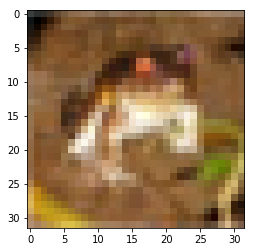

In [18]:
show_image(train_data[0])

## Prepare iterators

In [19]:
train = TupleDataset(train_data, train_labels)
valid = TupleDataset(test_data, test_labels)

batch_size = 128

train_iter = iterators.SerialIterator(train, batch_size)
valid_iter = iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)

## Build the model - LeNet5

In [20]:
class LeNet5LikeConvNet(Chain):
    def __init__(self):
        super(LeNet5LikeConvNet, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(3, 6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(6, 16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(16, 120, ksize=5, stride=1)
            self.fc4  = L.Linear(None, 84)
            self.out = L.Linear(84, 10)
    
    def normalize(self, x):
        X = F.reshape(x, (-1, 3, 32, 32))
        X = X / 255

        return X
    
    def __call__(self, x):
        X = self.normalize(x)

        a1 = F.relu(self.conv1(X))                                 # shape: (m, 6, 28, 28)
        a2 = F.max_pooling_2d(a1, 2, stride=2)        # shape: (m, 6, 14, 14)
        a3 = F.relu(self.conv2(a2))                              # shape: (m, 16, 10, 10)
        a4 = F.max_pooling_2d(a3, 2, stride=2)       # shape: (m, 16, 5, 5)
        a5 = F.relu(self.conv3(a4))                              # shape: (m, 120, 1, 1)
        a6 = F.relu(self.fc4(a5))                                  # shape: (m, 84)
        out =self.out(a6)                                              # shape: (m, 10) 
        
        if chainer.config.train:
            return out

        return F.softmax(out)

In [21]:
x0, y0 = train[0]
model = LeNet5LikeConvNet()

print("x0 type is {} and value is {}".format(type(x0), x0))
print("y0 type is {} and value is {}".format(type(y0), y0))

print("out type is {} and value is {}".format(type(model(x0)),  model(x0)))
print("out shape is {}".format(model(x0).shape))

x0 type is <class 'numpy.ndarray'> and value is [ 59.  43.  50. ... 140.  84.  72.]
y0 type is <class 'numpy.int32'> and value is 6
out type is <class 'chainer.variable.Variable'> and value is variable([[ 0.0400871   0.04615976 -0.03882615 -0.02823405  0.00059602
            0.0173551   0.01771353  0.03117665  0.1386121  -0.04671846]])
out shape is (1, 10)


## Train the model

In [55]:
def create_trainer(model,  train_iter, valid_iter, max_epoch=10, gpu_id = -1):
    if gpu_id >= 0:
        model.to_gpu(gpu_id)

    optimizer = optimizers.Adam()
    optimizer.setup(model)
    
    updater = training.updater.StandardUpdater(train_iter, optimizer, device=gpu_id)

    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='out/mnist')
    
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
    trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
    trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    return trainer

In [23]:
def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [24]:
reset_seed(0)

net = LeNet5LikeConvNet()
model = L.Classifier(net)

train_iter.reset()
valid_iter.reset()

trainer = create_trainer(model, train_iter, valid_iter, max_epoch=1)
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.74288     0.361973       2.12267               0.440071                  61.9117       


## Build the new model

Add some convolutional layers.

In [53]:
class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(3, 8, ksize=5)
            self.batch_norm1 = L.BatchNormalization(8)

            self.conv2 = L.Convolution2D(8, 16, ksize=5)
            self.batch_norm2 = L.BatchNormalization(16)
            
            self.conv3 = L.Convolution2D(16, 32, ksize=3, pad=1)
            self.batch_norm3 = L.BatchNormalization(32)
            
            self.conv4 = L.Convolution2D(32, 64, ksize=3)
            self.batch_norm4 = L.BatchNormalization(64)
            
            self.conv5 = L.Convolution2D(64, 512, ksize=3)
            self.batch_norm5 = L.BatchNormalization(512)

            self.fc6  = L.Linear(None, 84)
            self.fc7  = L.Linear(None, 84)            
            self.out = L.Linear(84, 10)
    
    def normalize(self, x):
        X = F.reshape(x, (-1, 3, 32, 32))
        X = X / 255

        return X
    
    def __call__(self, x):
        X = self.normalize(x)

        h = F.relu(self.batch_norm1(self.conv1(X)))  # shape: (m, 8, 28, 28)
        h = F.max_pooling_2d(h, 2, stride=2)             # shape: (m, 8, 14, 14)
        
        h = F.relu(self.batch_norm2(self.conv2(h)))  # shape: (m, 16, 10, 10)
        h = F.max_pooling_2d(h, 2, stride=2)             # shape: (m, 16, 5, 5)
        
        h = F.relu(self.batch_norm3(self.conv3(h)))  # shape: (m, 32, 5, 5)
        h = F.relu(self.batch_norm4(self.conv4(h)))  # shape: (m, 64, 3, 3) 
        h = F.relu(self.batch_norm5(self.conv5(h)))  # shape: (m, 512, 1, 1) 
        
        h = F.dropout(F.relu(self.fc6(h)))              # shape: (m, 128)
        h = F.dropout(F.relu(self.fc7(h)))              # shape: (m, 128)

        out =self.out(h)                                            # shape: (m, 10) 
        
        if chainer.config.train:
            return out

        return F.softmax(out)

In [39]:
reset_seed(0)

net = ConvNet()
model = L.Classifier(net)

train_iter.reset()
valid_iter.reset()

trainer = create_trainer(model, train_iter, valid_iter, max_epoch=30)
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.93145     0.26057        2.16844               0.389933                  99.3239       
2           1.63025     0.396839       2.09605               0.472211                  184.949       
3           1.50398     0.458834       2.0521                0.499901                  276.741       
4           1.41086     0.503796       2.0244                0.534711                  366.19        
5           1.34192     0.53155        2.01357               0.540843                  466.463       
6           1.2771      0.557372       2.01231               0.549446                  559.836       
7           1.22595     0.578465       1.98659               0.5714                    657.491       
8           1.17604     0.596094       1.95853               0.58218                   739.887       
9           1.1145      0.619645       1.94802               0.591179               

### Solve over-fitting

The main/loss is gradually reducing, but the validation/main/loss is in plateau. Let's solve over-fitting.

#### Weight decay

You can introduce Weight decay easily using just the following code.


```python
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.01))
```

Also, you can introduce Weight decay on fully connected layers as follows.


```
    net = YourConvNetModel()
    net.fc6.W.update_rule.add_hook(chainer.optimizer.WeightDecay(0.01))
```

In [60]:
reset_seed(0)

net = ConvNet()
model = L.Classifier(net)

train_iter.reset()
valid_iter.reset()

trainer = create_trainer(model, train_iter, valid_iter, max_epoch=30)
optimizer = trainer.updater.get_optimizer('main')
#optimizer.add_hook(chainer.optimizer.WeightDecay(0.01))

# Weight Decay for fully connected layers
net.fc6.W.update_rule.add_hook(chainer.optimizer.WeightDecay(0.03))
net.fc7.W.update_rule.add_hook(chainer.optimizer.WeightDecay(0.03))

trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.80402     0.33342        2.08875               0.464992                  90.955        
2           1.46783     0.47928        2.03105               0.5268                    183.008       
3           1.33523     0.536478       2.00521               0.550534                  275.787       
4           1.25297     0.570652       1.96927               0.585344                  369.986       
5           1.19268     0.595069       1.95462               0.597508                  465.256       
6           1.13964     0.616186       1.94514               0.607991                  561.709       
7           1.0997      0.631933       1.92637               0.620352                  658.121       
8           1.05472     0.645533       1.9172                0.61254                   754.86        
9           1.0229      0.659887       1.91587               0.614715               

## Consideration

It looks weight decay method successfully reduces over-fitting.


###### accuracy after 30-epochs

|   |  main/accuracy  | validation/main/accuracy  | 
|---|---|---|
| w/o weight decay  | 0.882792  | 0.596519 |
| w weight decay  | 0.811899  | 0.662085 |

